In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

# from scipy.cluster.hierarchy import dendrogram, linkage
# from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
# from sklearn.metrics import silhouette_score
# from sklearn.metrics.pairwise import euclidean_distances

# from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, select_dimension, selectSVD
from graspy.cluster import GaussianCluster, AutoGMMCluster

In [4]:
!ln -s /Users/TingshanLiu/Desktop/2020 summer/TL_maggot/notebooks/RecursiveCluster_v5.py RecursiveCluster_v5.py
from RecursiveCluster_v5 import RecursiveCluster

usage: ln [-Ffhinsv] source_file [target_file]
       ln [-Ffhinsv] source_file ... target_dir
       link source_file target_file


### 3-level synthetic Gaussian data (1D, 2GM)

In [5]:
def calculate_means(loc_scale, center, length, level):
    means = [center-length, center+length]
    for lvl in range(level-1):
        length = length * loc_scale
        for i in range(len(means)):
            means[i] = [means[i]-length, means[i]+length]
            means = list(np.array(means).ravel())
    return means

In [6]:
def GM_data(cov_scale, n_sample, loc_scale=0.3):

    length = 10
    n_level = 3
    n_GM = 2

    means = calculate_means(loc_scale, center=0, length=length, level=n_level)

    n_class = len(means)
    x = list(np.zeros((n_class, 1)))
    for i in range(n_class):
        x[i] = [np.random.normal(means[i], cov_scale, size=(n_sample, 1))]
    x = np.array(x).ravel()
    
    n_total_sample = n_sample * (n_GM ** n_level)
    y = np.zeros((n_total_sample, n_level))
    for lvl in range(n_level):
        n_repeat = n_total_sample // (n_GM ** (lvl+1))
        y[:,lvl] = np.repeat(range(n_GM**(lvl+1)), n_repeat)

    return x, y

#### plot sample data distribution

In [6]:
x_1 = np.empty((1, 1))
x_3 = np.empty((1, 1))
x_5 = np.empty((1, 1))
for i in range(100):
    x_1 = np.append(x_1, GM_data(0.1, 100)[0].reshape((-1, 1)), axis=0)  # loc_scale = 0.1
    x_3 = np.append(x_3, GM_data(0.3, 100)[0].reshape((-1, 1)), axis=0)  # loc_scale = 0.3
    x_5 = np.append(x_5, GM_data(0.5, 100)[0].reshape((-1, 1)), axis=0)  # loc_scale = 0.5

x_all = {}
x_all[0] = x_1[1:]
x_all[1] = x_3[1:]
x_all[2] = x_5[1:]

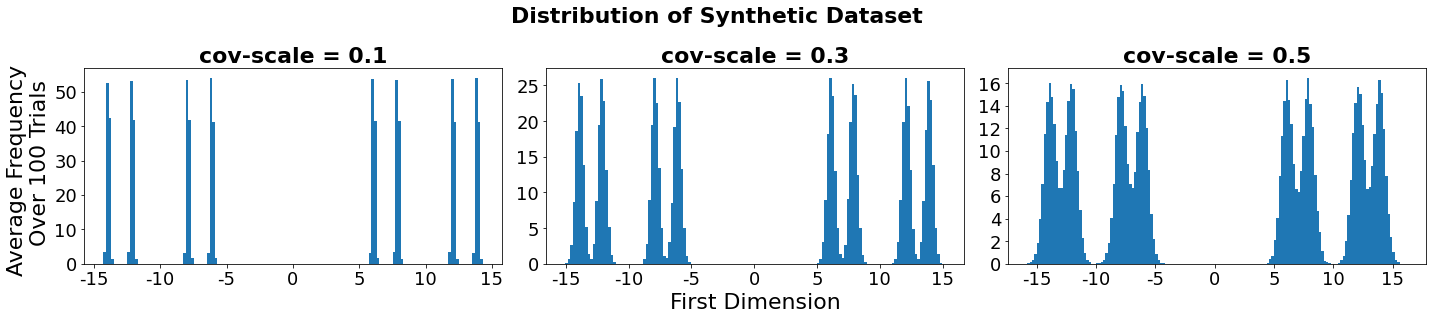

In [74]:
fig, axs = plt.subplots(1,3, figsize=(20,4))
binwidth = 0.2
scales = [0.1, 0.3, 0.5]

for i in range(3):
    ax = axs[i]
    x = x_all[i]
    ax.hist(x, bins=np.arange(min(x), max(x) + binwidth, binwidth))
    ax.set_title(f"cov-scale = %.1f"%(scales[i]), fontsize=22, fontweight='bold')
    ax.set_yticklabels((ax.get_yticks()/100).astype(int),fontsize=18)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=18)
    if i == 0:
        ax.set_ylabel("Average Frequency \n Over 100 Trials", fontsize=22)
    if i == 1:
        ax.set_xlabel("First Dimension", fontsize=22)

fig.suptitle("Distribution of Synthetic Dataset", fontsize=22, fontweight='bold', y=1.1)
plt.tight_layout()
plt.savefig("hist")

#### heatmap of clustering labels

In [79]:
def heatmap_label(pred_sorted, nbins, ndecimal, title, figname):
    p = pred_sorted.copy()
    n_level = p.shape[1]
    ari = np.zeros((n_level,2))
    for l in range(n_level):
        if l <= 2:
            ari[l,0] = adjusted_rand_score(y[:,l], p[:,l])
            ari[l,1] = 2**(l+1)
        else:
            ari[l,0] = adjusted_rand_score(y[:,-1], p[:,l])
            ari[l,1] = 8

    fig,axs = plt.subplots(n_level,2, figsize=(24, n_level+1.5), gridspec_kw=dict(width_ratios=[4,20]))
    for i in range(n_level): 
        ax = axs[i,1]
        sns.heatmap(p[:, n_level-i-1].reshape((1,-1))+1, annot = False, cbar=False, xticklabels=100, yticklabels="", square = False, cmap = 'RdBu_r', center=0, ax=ax)
        ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=18)
        if i < p.shape[1]-1:
            ax.set(xticklabels='')
        else:
            ax.set_xlabel("Node Index", fontsize=22)
        if i == 0:
            ax.set_title(title, fontsize=22, fontweight='bold', y=1.1)
        # ax.set_ylabel(f"lvl%i \n"%(i+1) + f"%i clus \n"%(max(p[:,i])+1), fonsize=22)

    gs = axs[0, 0].get_gridspec()

    for ax in axs[:,0]:
        ax.remove()
    ax1 = fig.add_subplot(gs[:,0])

    # line = sns.lineplot(y=np.arange(len(ari))+1, x=ari[:,0], ax=ax_new, linewidth=10)
    # plot ARIs
    ax1.plot(ari[:,0], np.arange(len(ari))+1, linewidth=2, color="red")

    # set x-axis
    ax1.set_xlabel("ARI", fontsize=22, color="red")
    plt.xticks(rotation=90)
    ax1.locator_params("x", tight=True, nbins=nbins)
    ax1.set_xlim((None, 1.01))
    ax1.set_xlim(ax1.get_xlim()[::-1])
    ax1.set_xticklabels(np.round(ax1.get_xticks(), ndecimal), fontsize=18, color="red")

    # set y-axis
    ax1.set_ylabel("Max Depth", fontsize=22)
    ax1.set_yticks(np.arange(0, n_level, 1) + 1)
    ax1.yaxis.tick_right()
    for tick in ax1.get_yticklabels():
        tick.set_rotation(90)
    ax1.yaxis.set_label_position("right")
    ax1.set_yticklabels(np.arange(0, n_level, 1) + 1, fontsize=18)
    
    # plot # clusters
    n_clusters = [max(p[:,i]+1) for i in range(n_level)]
    ax2 = ax1.twiny()
    ax2.plot(n_clusters, np.arange(len(ari))+1, linewidth=2, color="blue")

    # set x-axis
    ax2.set_xlabel("# clusters", fontsize=22, color="blue")
    plt.xticks(rotation=90)
    ax2.locator_params("x", tight=True)
    ax2.set_xlim(ax2.get_xlim()[::-1])
    ax2.set_xticks(np.arange(2, n_clusters[-1]+1, 2))
    ax2.set_xticklabels(ax2.get_xticks(), fontsize=18, color="blue")

    plt.subplots_adjust(wspace=0.1)
    # plt.show()
    plt.tight_layout()
    plt.savefig(figname)


In [9]:
def relabel(pred):
    # reorder the labels so that the clusters in each array
    # recieve increasing labels
    for i in range(pred.shape[1]):
        temp = pred[:,i].copy()
        _, index = np.unique(temp, return_index=True)
        # return unique labels in the order of their appearance
        uni_labels = temp[np.sort(index)]
        for label, ul in enumerate(uni_labels):
            inds = temp == ul
            temp[inds] = -label-1
        pred[:,i] = -(temp+1)
        
    return pred

In [7]:
np.random.seed(3)
rc = RecursiveCluster(max_level=6)
x, y = GM_data(0.1, 100)
x = x.reshape((-1,1))
pred_scale1 = rc.fit_predict(x)

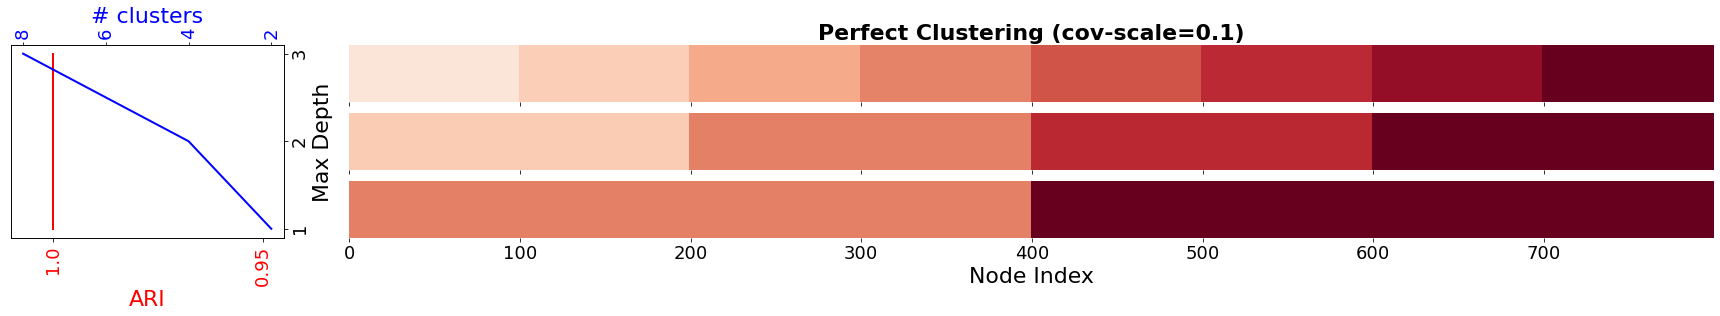

In [80]:
heatmap_label(relabel(pred_scale1), 2, 4, "Perfect Clustering (cov-scale=0.1)", "perfect clus")


In [20]:
# rc = RecursiveCluster(max_level=6)
# x, y = GM_data(0.3, 100)
# x = x.reshape((-1, 1))
# pred_scale3 = rc.fit_predict(x)

In [21]:
# heatmap_label(relabel(pred_scale3), 3, 4)

In [52]:
np.random.seed(4)
rc = RecursiveCluster(max_level=6)
x, y = GM_data(0.5, 100)
x = x.reshape((-1,1))
pred_scale5 = rc.fit_predict(x)

In [53]:
pred_scale5

array([[1, 1, 0, 2],
       [1, 1, 0, 2],
       [1, 1, 0, 2],
       ...,
       [0, 2, 6, 8],
       [0, 2, 6, 8],
       [0, 2, 6, 8]])

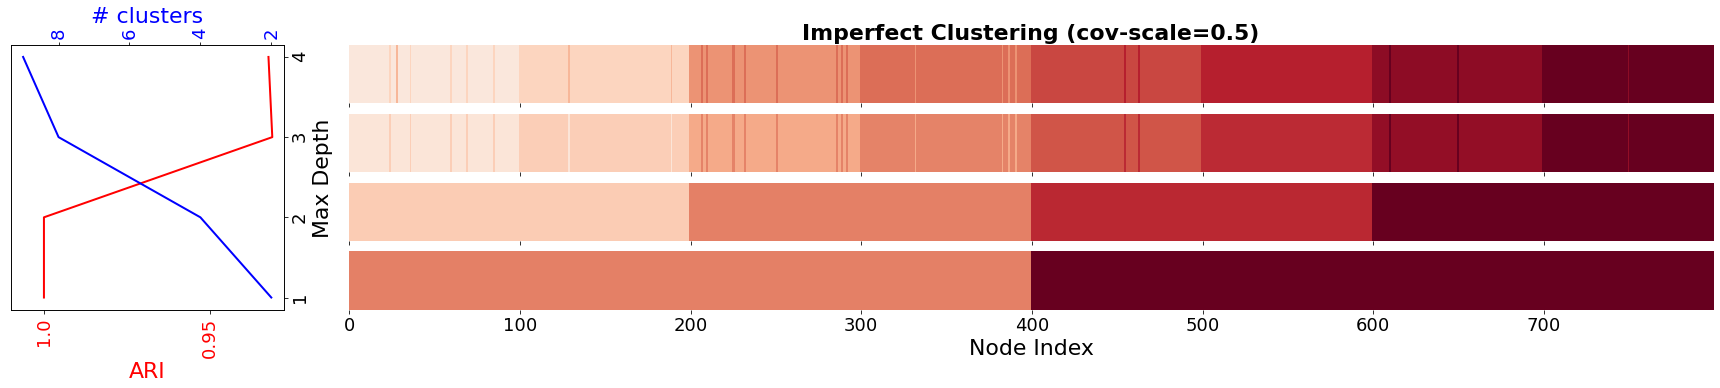

In [81]:
heatmap_label(relabel(pred_scale5), 2, 4, "Imperfect Clustering (cov-scale=0.5)", "imperfect clus")

In [571]:
# pred_sorted_all = {}
# pred_sorted_all[0] = relabel(pred_scale1)
# pred_sorted_all[1] = relabel(pred_scale3)
# pred_sorted_all[2] = relabel(pred_scale5)

# # fig,axs = plt.subplots(3, 1, figsize=(30,30))
# for i in range(3):
#     # ax = axs[0]
#     plt.subplot(3,1,i+1)
#     fig, ax = heatmap_label(pred_sorted_all[i], 2, 4)
#     # fig.add_subplot(i11)

In [551]:
from matplotlib importgridspec 

In [568]:
def heatmap_label(pred_sorted, nbins, ndecimal, outer, nfig, fig):
    p = pred_sorted.copy()
    n_level = p.shape[1]

    inner = gridspec.GridSpecFromSubplotSpec(n_level, 2, subplot_spec=outer[nfig], width_ratios=[4,20])
    # inner = outer.subgridspec(n_level, 2, gridspec_kw=dict(width_ratios=[4,20]))
    # axs = plt.Subplot(fig, inner[:,1])
    # print(axs)
    
    ari = np.zeros((n_level,2))
    for l in range(n_level):
        if l <= 2:
            ari[l,0] = adjusted_rand_score(y[:,l], p[:,l])
            ari[l,1] = 2**(l+1)
        else:
            ari[l,0] = adjusted_rand_score(y[:,-1], p[:,l])
            ari[l,1] = 8

    # fig,axs = plt.subplots(n_level,2, figsize=(24, n_level+1.5), gridspec_kw=dict(width_ratios=[4,20]))
    for i in range(n_level): 
        # ax = axs[i,1]
        # ax = axs[i]
        ax = plt.Subplot(fig, inner[i,1])
        sns.heatmap(p[:, n_level-i-1].reshape((1,-1))+1, annot = False, cbar=False, xticklabels=100, yticklabels="", square = False, cmap = 'RdBu_r', center=0, ax=ax)
        ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=18)
        if i < p.shape[1]-1:
            ax.set(xticklabels='')
        else:
            ax.set_xlabel("Node Index", fontsize=22)
        # ax.set_ylabel(f"lvl%i \n"%(i+1) + f"%i clus \n"%(max(p[:,i])+1), fonsize=22)

    ax = plt.Subplot(fig, inner[:,0])
    gs = ax.get_gridspec()
    # gs = axs[0, 0].get_gridspec()

    # for ax in axs[:,0]:
    #     ax.remove()
    ax1 = fig.add_subplot(gs[:,0])

    # line = sns.lineplot(y=np.arange(len(ari))+1, x=ari[:,0], ax=ax_new, linewidth=10)
    # plot ARIs
    ax1.plot(ari[:,0], np.arange(len(ari))+1, linewidth=2, color="red")

    # set x-axis
    ax1.set_xlabel("ARI", fontsize=22, color="red")
    plt.xticks(rotation=90)
    ax1.locator_params("x", tight=True, nbins=nbins)
    ax1.set_xlim((None, 1.01))
    ax1.set_xlim(ax1.get_xlim()[::-1])
    ax1.set_xticklabels(np.round(ax1.get_xticks(), ndecimal), fontsize=18, color="red")

    # set y-axis
    ax1.set_ylabel("Max Depth", fontsize=22)
    ax1.set_yticks(np.arange(0, n_level, 1) + 1)
    ax1.yaxis.tick_right()
    for tick in ax1.get_yticklabels():
        tick.set_rotation(90)
    ax1.yaxis.set_label_position("right")
    ax1.set_yticklabels(np.arange(0, n_level, 1) + 1, fontsize=18)
    
    # plot # clusters
    n_clusters = [max(p[:,i]+1) for i in range(n_level)]
    ax2 = ax1.twiny()
    ax2.plot(n_clusters, np.arange(len(ari))+1, linewidth=2, color="blue")

    # set x-axis
    ax2.set_xlabel("# clusters", fontsize=22, color="blue")
    plt.xticks(rotation=90)
    ax2.locator_params("x", tight=True)
    ax2.set_xlim(ax2.get_xlim()[::-1])
    ax2.set_xticks(np.arange(2, n_clusters[-1]+1, 2))
    ax2.set_xticklabels(ax2.get_xticks(), fontsize=18, color="blue")

    plt.subplots_adjust(wspace=0.1)
    plt.show()
    # plt.tight_layout()

    # return 

#### plot ARI strips

In [2]:
pickle_in = open("pred_all-fixed_means-line-3lvl-100samples-50replicate-loc=pt3-cov=all-bi-non_bi.pickle", "rb")
pred_all = pickle.load(pickle_in)

In [8]:
n = 50
ARIs = {}
scales = [0,2,4]  # scales index
for s in range(len(scales)):
    for i in range(n):
        pred = pred_all['bi',scales[s],i]
        ARI = np.zeros((y.shape[1], pred.shape[1]))
        for j in range(y.shape[1]):
            for k in range(pred.shape[1]):
                ARI[j,k] = adjusted_rand_score(y[:,j], pred[:,k])
        if ARI.shape[1] > 6:
            ARI = ARI[:, :6]
        ARIs[s,i] = ARI

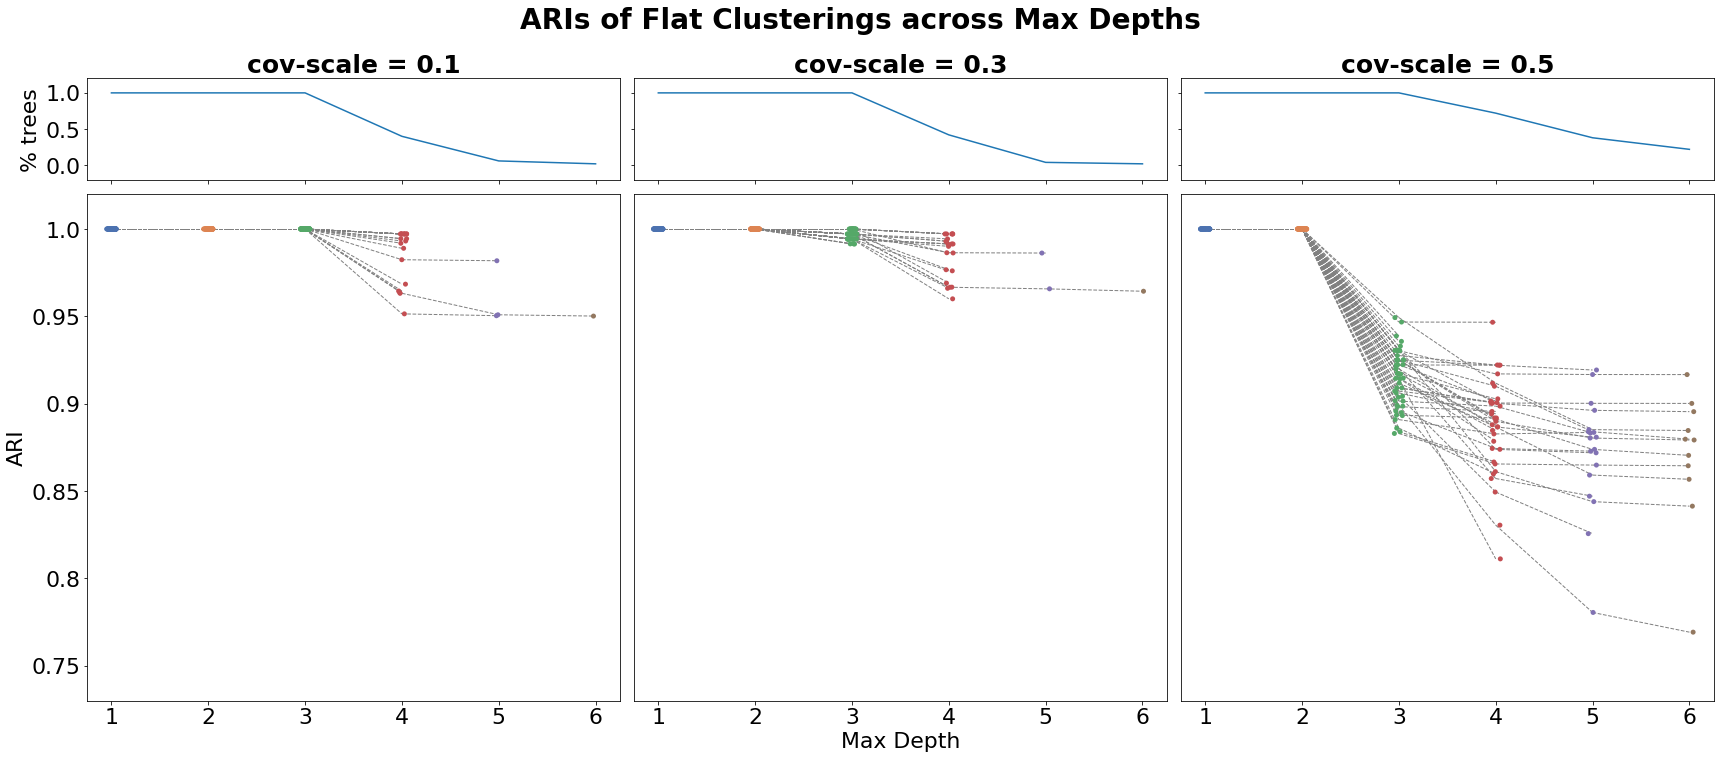

In [10]:
fig,axs = plt.subplots(2,3, figsize=(24,10), gridspec_kw=dict(height_ratios=[1,5]))
scales = [0.1, 0.3, 0.5]
for j1 in range(3):
    ax = axs[1, j1]
    b = [ARIs[j1,i] for i in range(n)]
    df = pd.DataFrame([])
    for i in range(n):
        b1 = [b[i][0,0], b[i][1,1]]
        for j in range(len(b[i][2,2:])):
            b1.append(b[i][2,2:][j])
        b1 = pd.DataFrame(np.array(b1).reshape(1,-1))
        df = pd.concat([df, b1])

    df.columns = [n+1 for n in range(df.shape[1])]
    df1 = df
    df = df.melt(value_vars=[n+1 for n in range(df.shape[1])], var_name="level", value_name="ARI")
    # plot ARIs
    sns.stripplot(data=df, x="level", y="ARI", ax=ax, palette="deep", jitter=0.05)

    # plot traces
    for i in range(df1.shape[1]-1):
        ax.plot([np.zeros((n))+i, np.zeros((n))+i+1],[df1.iloc[:,i], df1.iloc[:,i+1]], color = 'grey', linewidth = 1, linestyle = '--')

    # set axes
    ax.set(ylim=(0.73, 1.02), xlim=(-0.25, 5.25))
    if j1 != 1:
        ax.set(xlabel="")
    else:
        ax.set_xlabel("Max Depth", fontsize=22)
    ax.set_ylabel("ARI", fontsize=22)
    if j1 != 0:
        ax.set_yticks([])
        ax.set(ylabel="")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=22)
    ax.set_yticklabels(np.round(ax.get_yticks(), 3), fontsize=22)

    # plot % trees
    ns = [df1[i+1].count() for i in range(df1.shape[1])][:6]
    ns = np.array(ns) / n

    ax = axs[0, j1]
    ax.plot(np.arange(6), ns)
    ax.set_title("cov-scale = %.1f"%(scales[j1]), fontsize=25, fontweight='bold')
    ax.set_xticklabels("")
    ax.set(ylim=(-0.2,1.2))
    ax.set_yticklabels(ax.get_yticks(), fontsize=22)
    if j1 == 0:
        ax.set_ylabel("% trees", fontsize=22)
    else:
        ax.set_yticklabels("")

fig.suptitle("ARIs of Flat Clusterings across Max Depths", fontsize=28, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig("ARIs")